In [1]:
!pip install git+https://github.com/messari/messari-python-api.git
!pip install pmdarima

  Cloning https://github.com/messari/messari-python-api.git to /private/var/folders/ks/0nlmbx4j0rg3pzjsgw_7b7rw0000gn/T/pip-req-build-eai0pnvy
  Running command git clone -q https://github.com/messari/messari-python-api.git /private/var/folders/ks/0nlmbx4j0rg3pzjsgw_7b7rw0000gn/T/pip-req-build-eai0pnvy
  Resolved https://github.com/messari/messari-python-api.git to commit 79a204e6a12111402833287e4fdbdb088d22fa4a


In [2]:
from messari.messari import Messari

messari = Messari()
assets = ['bitcoin']
metric = 'price'
start = '2020-01-01'
end = '2023-01-01'
df = messari.get_metric_timeseries(asset_slugs=assets, asset_metric=metric, start=start, end=end)
df = df[f'{assets[0]}']

In [3]:
dates = df.reset_index()['timestamp'].tolist()
close = df['close'].tolist()

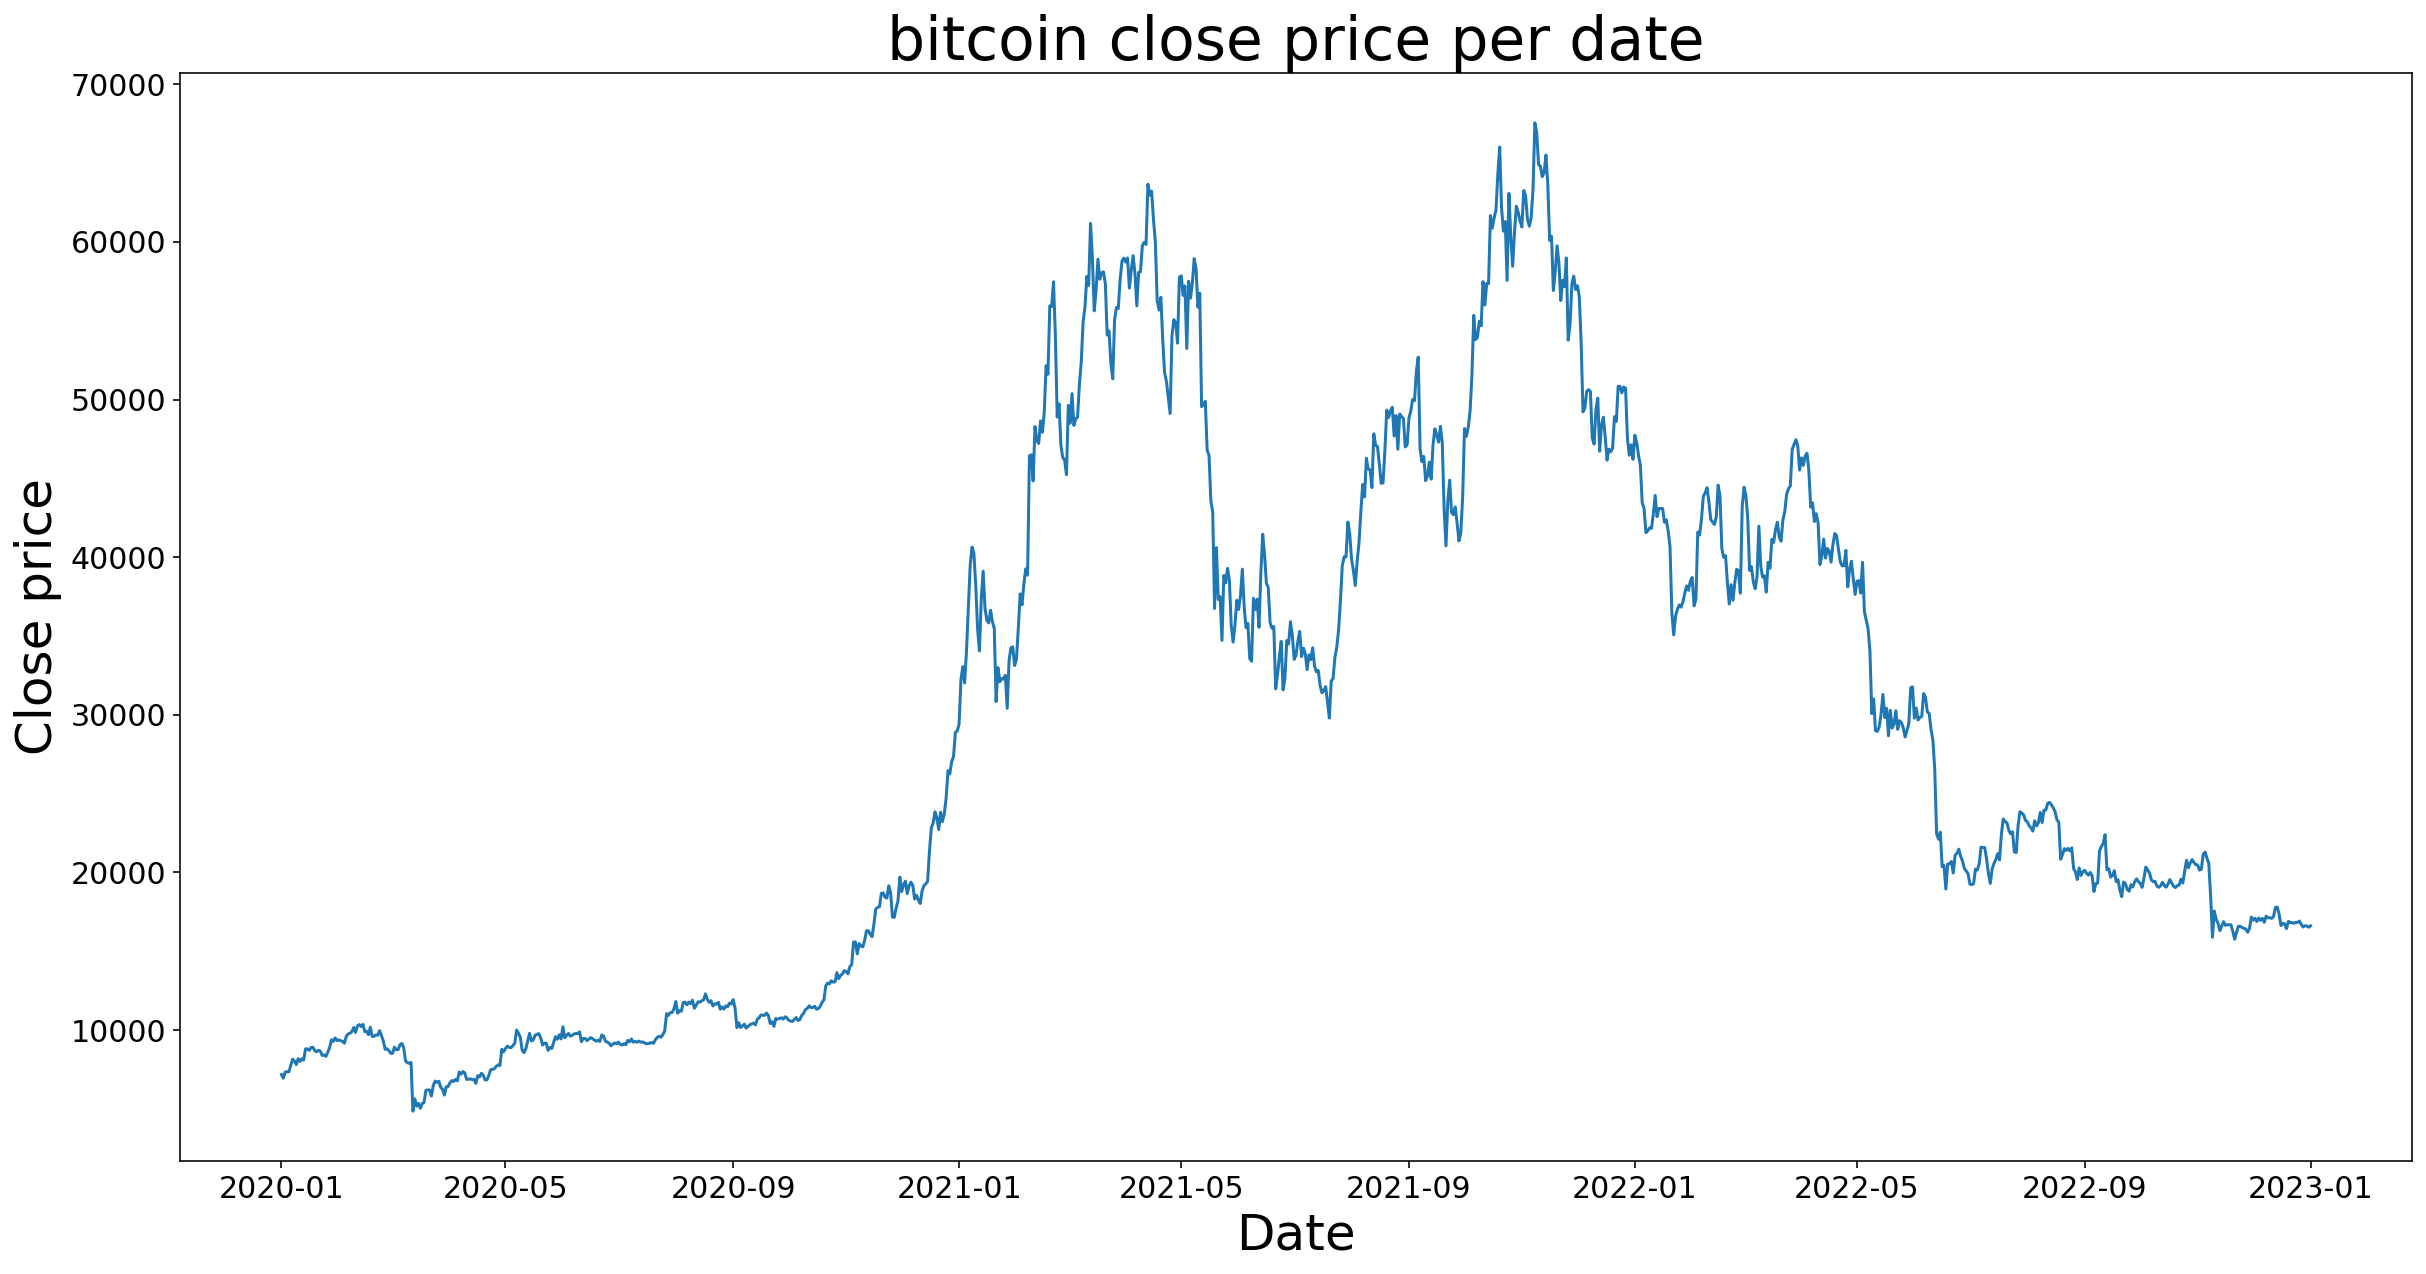

In [4]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 20, 10
plt.plot(dates, close)
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Close price", fontsize = 25)
plt.title(f"{assets[0]} close price per date", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

period = 7
train, test = train_test_split(close, test_size=period, shuffle=False)
train_dates, test_dates = train_test_split(dates, test_size=period, shuffle=False)
train, val = train_test_split(train, test_size=period, shuffle=False)
train_dates, val_dates = train_test_split(train_dates, test_size=period, shuffle=False)

In [6]:
from statsmodels.tsa.stattools import adfuller

d = 0
if adfuller(train)[1] >= 0.05:
    print('Data is not stationary')
    d += 1
else:
    print('Data is stationary')

Data is not stationary


### Auto ARIMA implementation. ###

In [7]:
from pmdarima.arima import auto_arima

model = auto_arima(train+val, max_p=5, d=d, max_q=15, max_order=30, seasonal=False, stepwise=False)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1090
Model:               SARIMAX(2, 1, 4)   Log Likelihood               -9344.569
Date:                Tue, 16 May 2023   AIC                          18705.139
Time:                        02:06:53   BIC                          18745.083
Sample:                             0   HQIC                         18720.258
                               - 1090                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.0220     97.090      0.083      0.934    -182.271     198.314
ar.L1         -0.4748      0.015    -31.596      0.000      -0.504      -0.445
ar.L2         -0.9613      0.015    -64.727      0.0

In [8]:
auto_arima_order = (model.get_params()['order'])
auto_arima_order

(2, 1, 4)

In [9]:
from sklearn.metrics import mean_squared_error

test_pred = model.predict(period)
test_RMSE = mean_squared_error(test, test_pred, squared=False)
test_rel_error = ((abs(test - test_pred)) / test) * 100

print("Test RMSE = %.3f" % test_RMSE, sep="")
print("Test relative error = %.3f" % test_rel_error.mean(), '%', sep="")
print("Last test relative error = %.3f" % test_rel_error[-1], '%', sep="")

Test RMSE = 236.481
Test relative error = 1.345%
Last test relative error = 1.443%


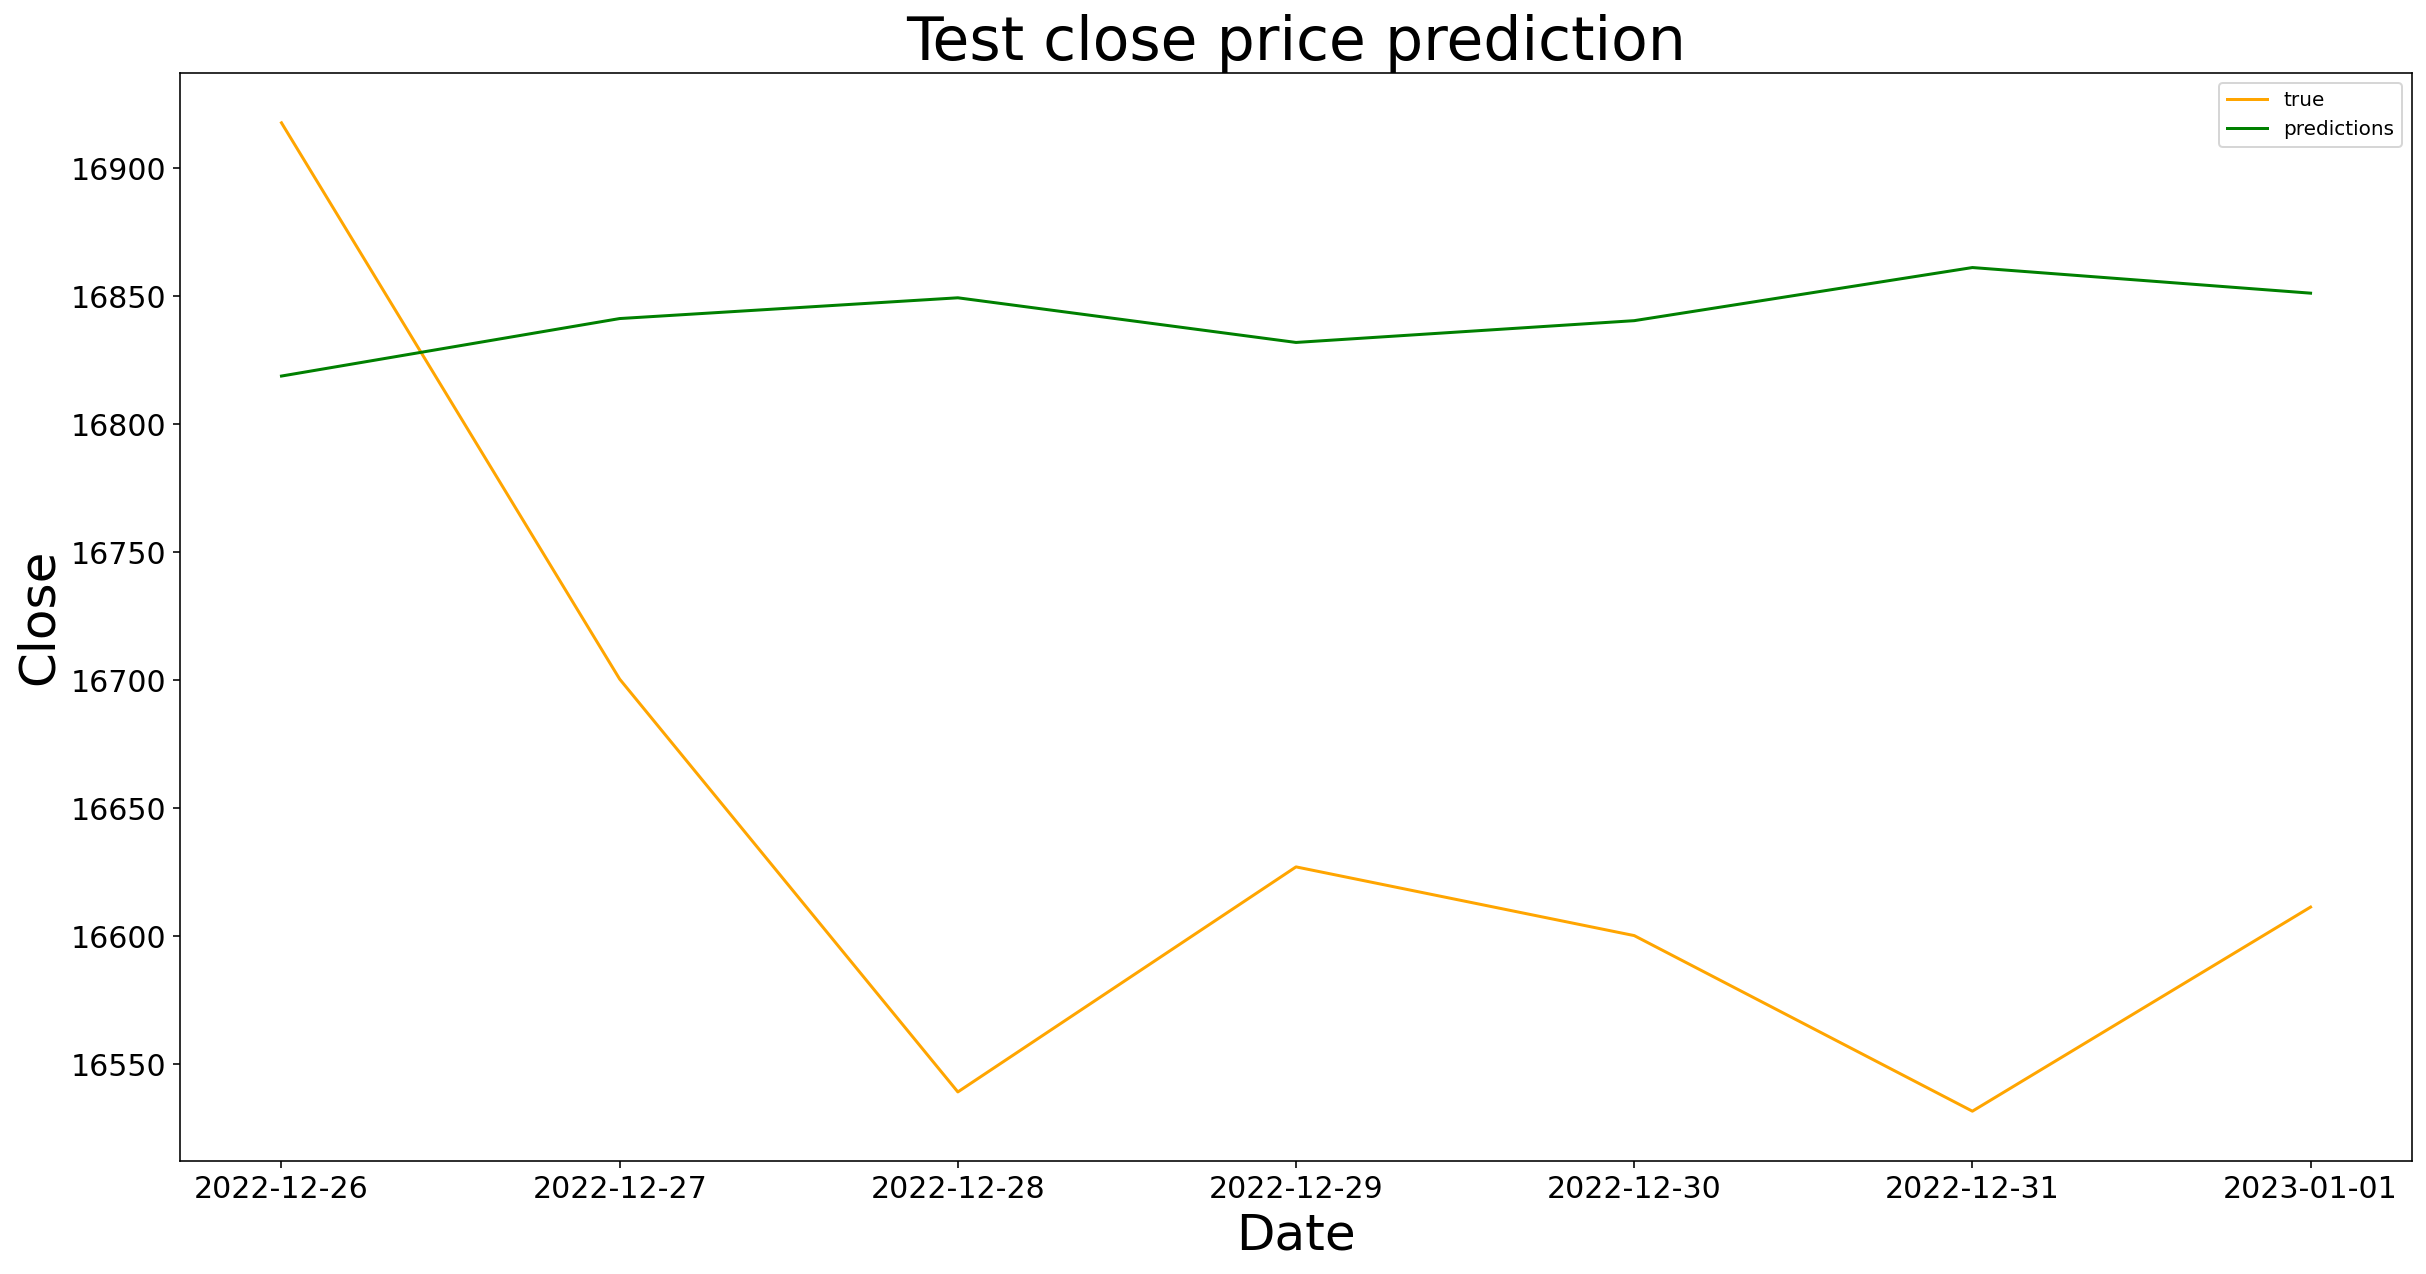

In [10]:
plt.plot(test_dates, test, color = 'orange', label = 'true')
plt.plot(test_dates, test_pred, color = 'green', label = 'predictions')
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Close", fontsize = 25)
plt.title("Test close price prediction", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()
plt.show()

### Now lets tune p, d, r parameters with grid search. ###

/Users/alexander/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


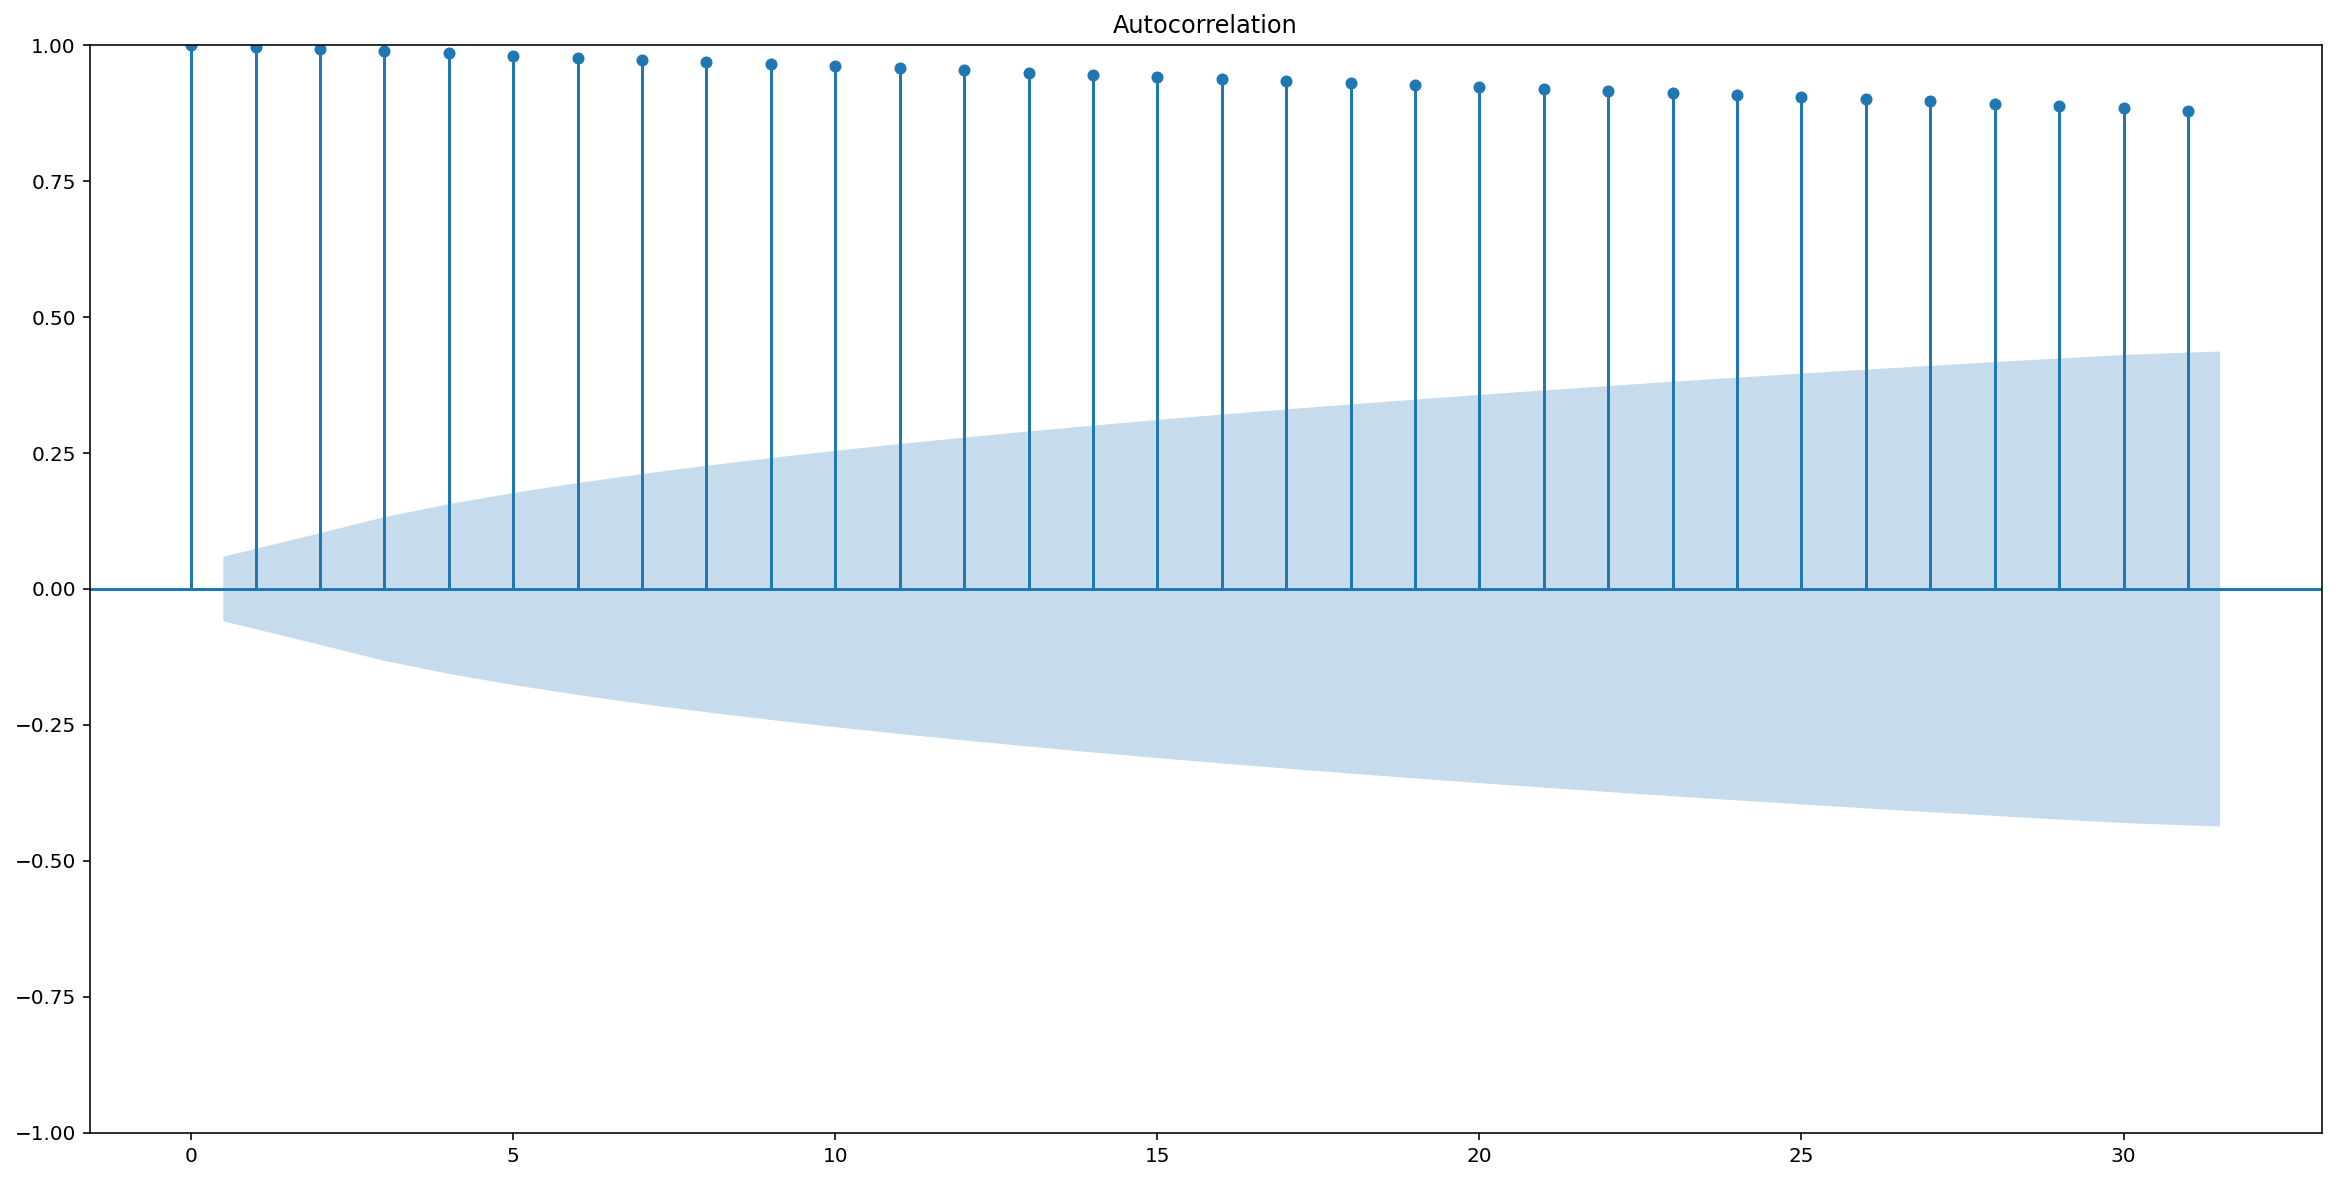

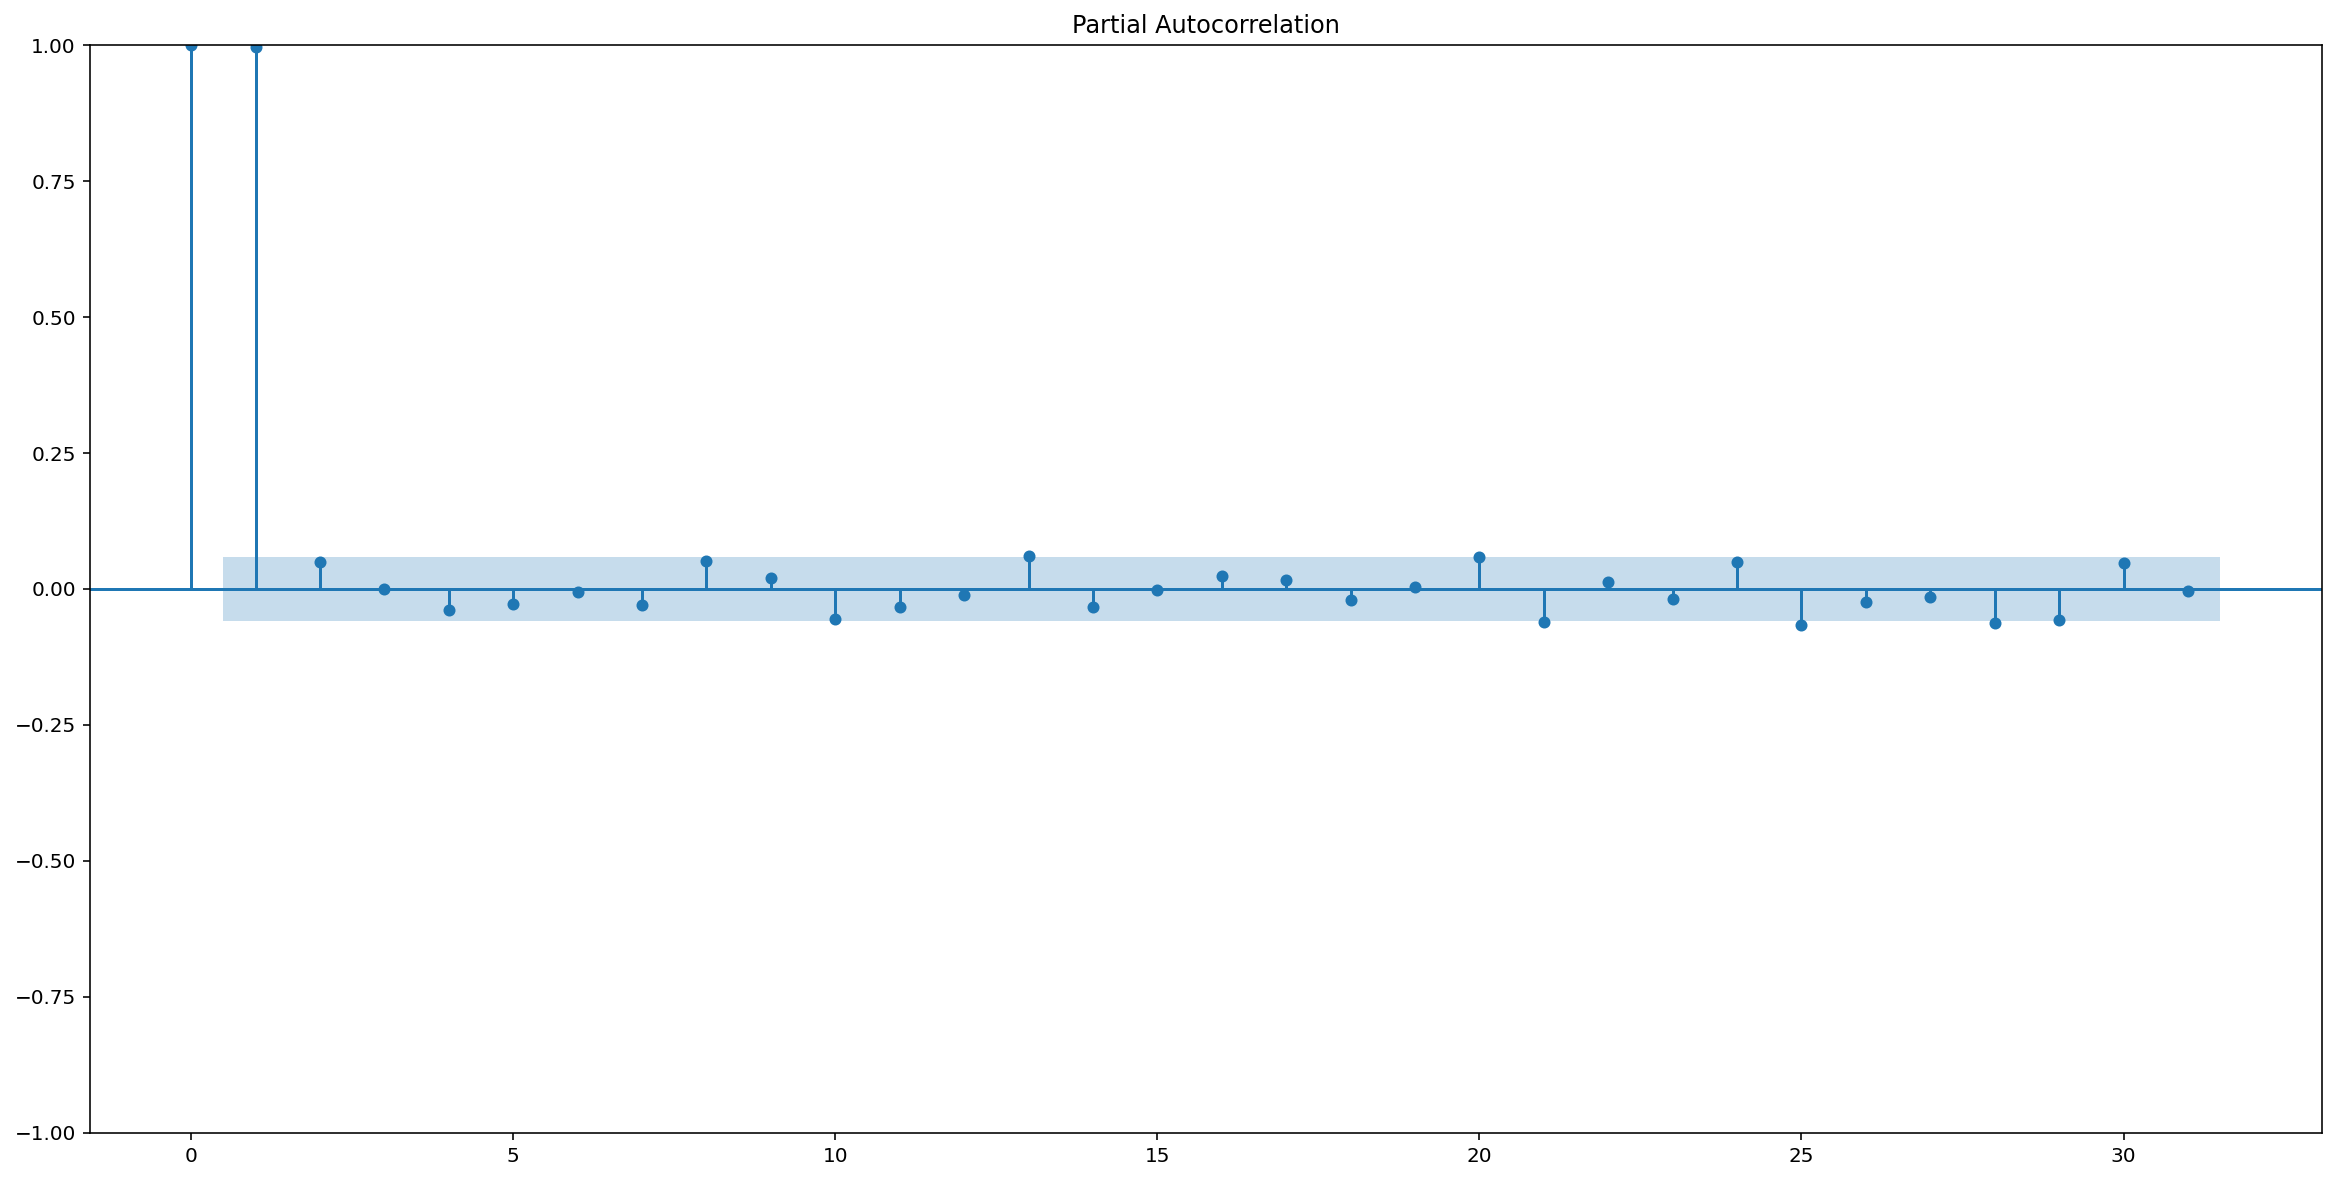

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(df['close'][:-period])
plot_pacf(df['close'][:-period])
plt.show()

In [12]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
import numpy as np

p_values = range(0, 6)
q_values = range(0, 16)
best_RMSE = np.inf
best_arima_order = (0, 0, 0)

for p_ in p_values:
    for q_ in q_values:
        warnings.filterwarnings("ignore")
        order_ = (p_,d,q_)
        model_ = ARIMA(train, order=order_).fit()
        val_pred_ = model_.forecast(period)
        val_RMSE_ = mean_squared_error(val, val_pred_, squared=False)
        if val_RMSE_ < best_RMSE:
            best_RMSE = val_RMSE_
            best_arima_order = order_

print("Best RMSE = %.3f" % best_RMSE, sep="")
print("Best arima order = ", best_arima_order, sep="")

Best RMSE = 118.576
Best arima order = (4, 1, 6)


In [13]:
best_model = ARIMA(train, order=best_arima_order).fit()
val_pred_ = best_model.forecast(period)
val_RMSE_ = mean_squared_error(val, val_pred_, squared=False)
val_rel_error_ = ((abs(val - val_pred_)) / val) * 100
print("Validation RMSE = %.3f" % val_RMSE_, sep="")
print("Validation relative error = %.3f" % val_rel_error_.mean(), '%', sep="")
print("Last validation relative error = %.3f" % val_rel_error_[-1], '%', sep="")

Validation RMSE = 118.576
Validation relative error = 0.606%
Last validation relative error = 0.157%


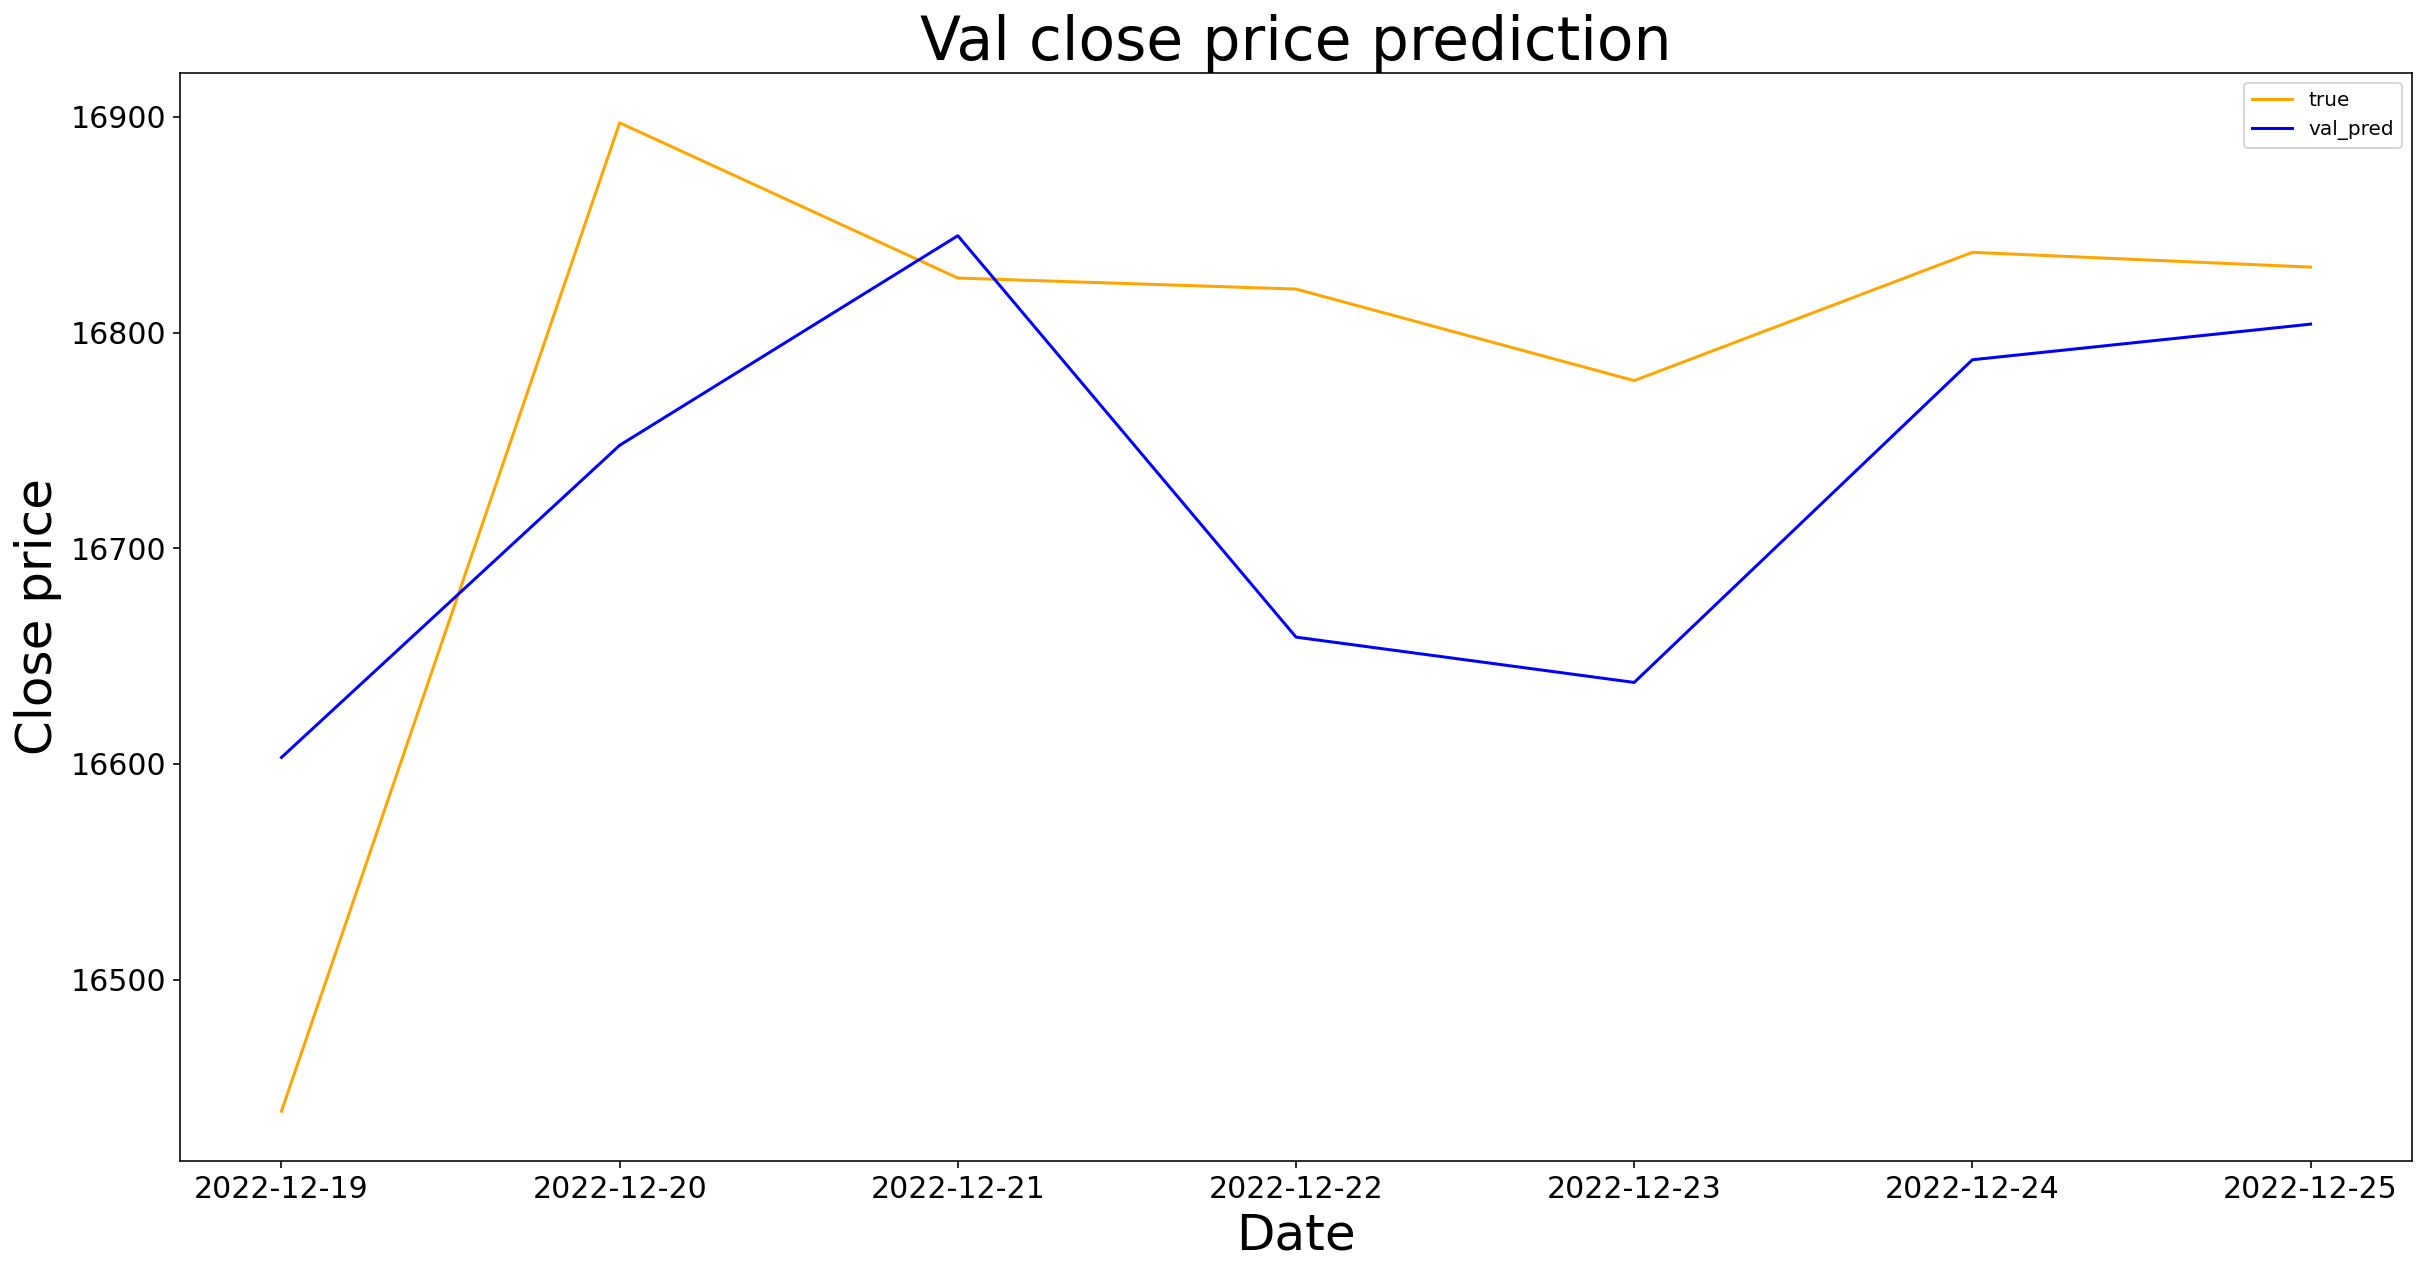

In [14]:
plt.title("Val close price prediction", fontsize = 30)
plt.plot(val_dates, val, color = 'orange', label = 'true')
plt.plot(val_dates, val_pred_, color = 'blue', label = 'val_pred')
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Close price", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()
plt.show()

In [15]:
best_model = ARIMA(train+val, order=best_arima_order).fit()
test_pred_ = best_model.forecast(period)
test_RMSE_ = mean_squared_error(test, test_pred_, squared=False)
test_rel_error_ = ((abs(test - test_pred_)) / test) * 100
print("Test RMSE = %.3f" % test_RMSE_, sep="")
print("Test relative error = %.3f" % test_rel_error_.mean(), '%', sep="")
print("Last test relative error = %.3f" % test_rel_error_[-1], '%', sep="")

Test RMSE = 192.566
Test relative error = 1.028%
Last test relative error = 1.368%


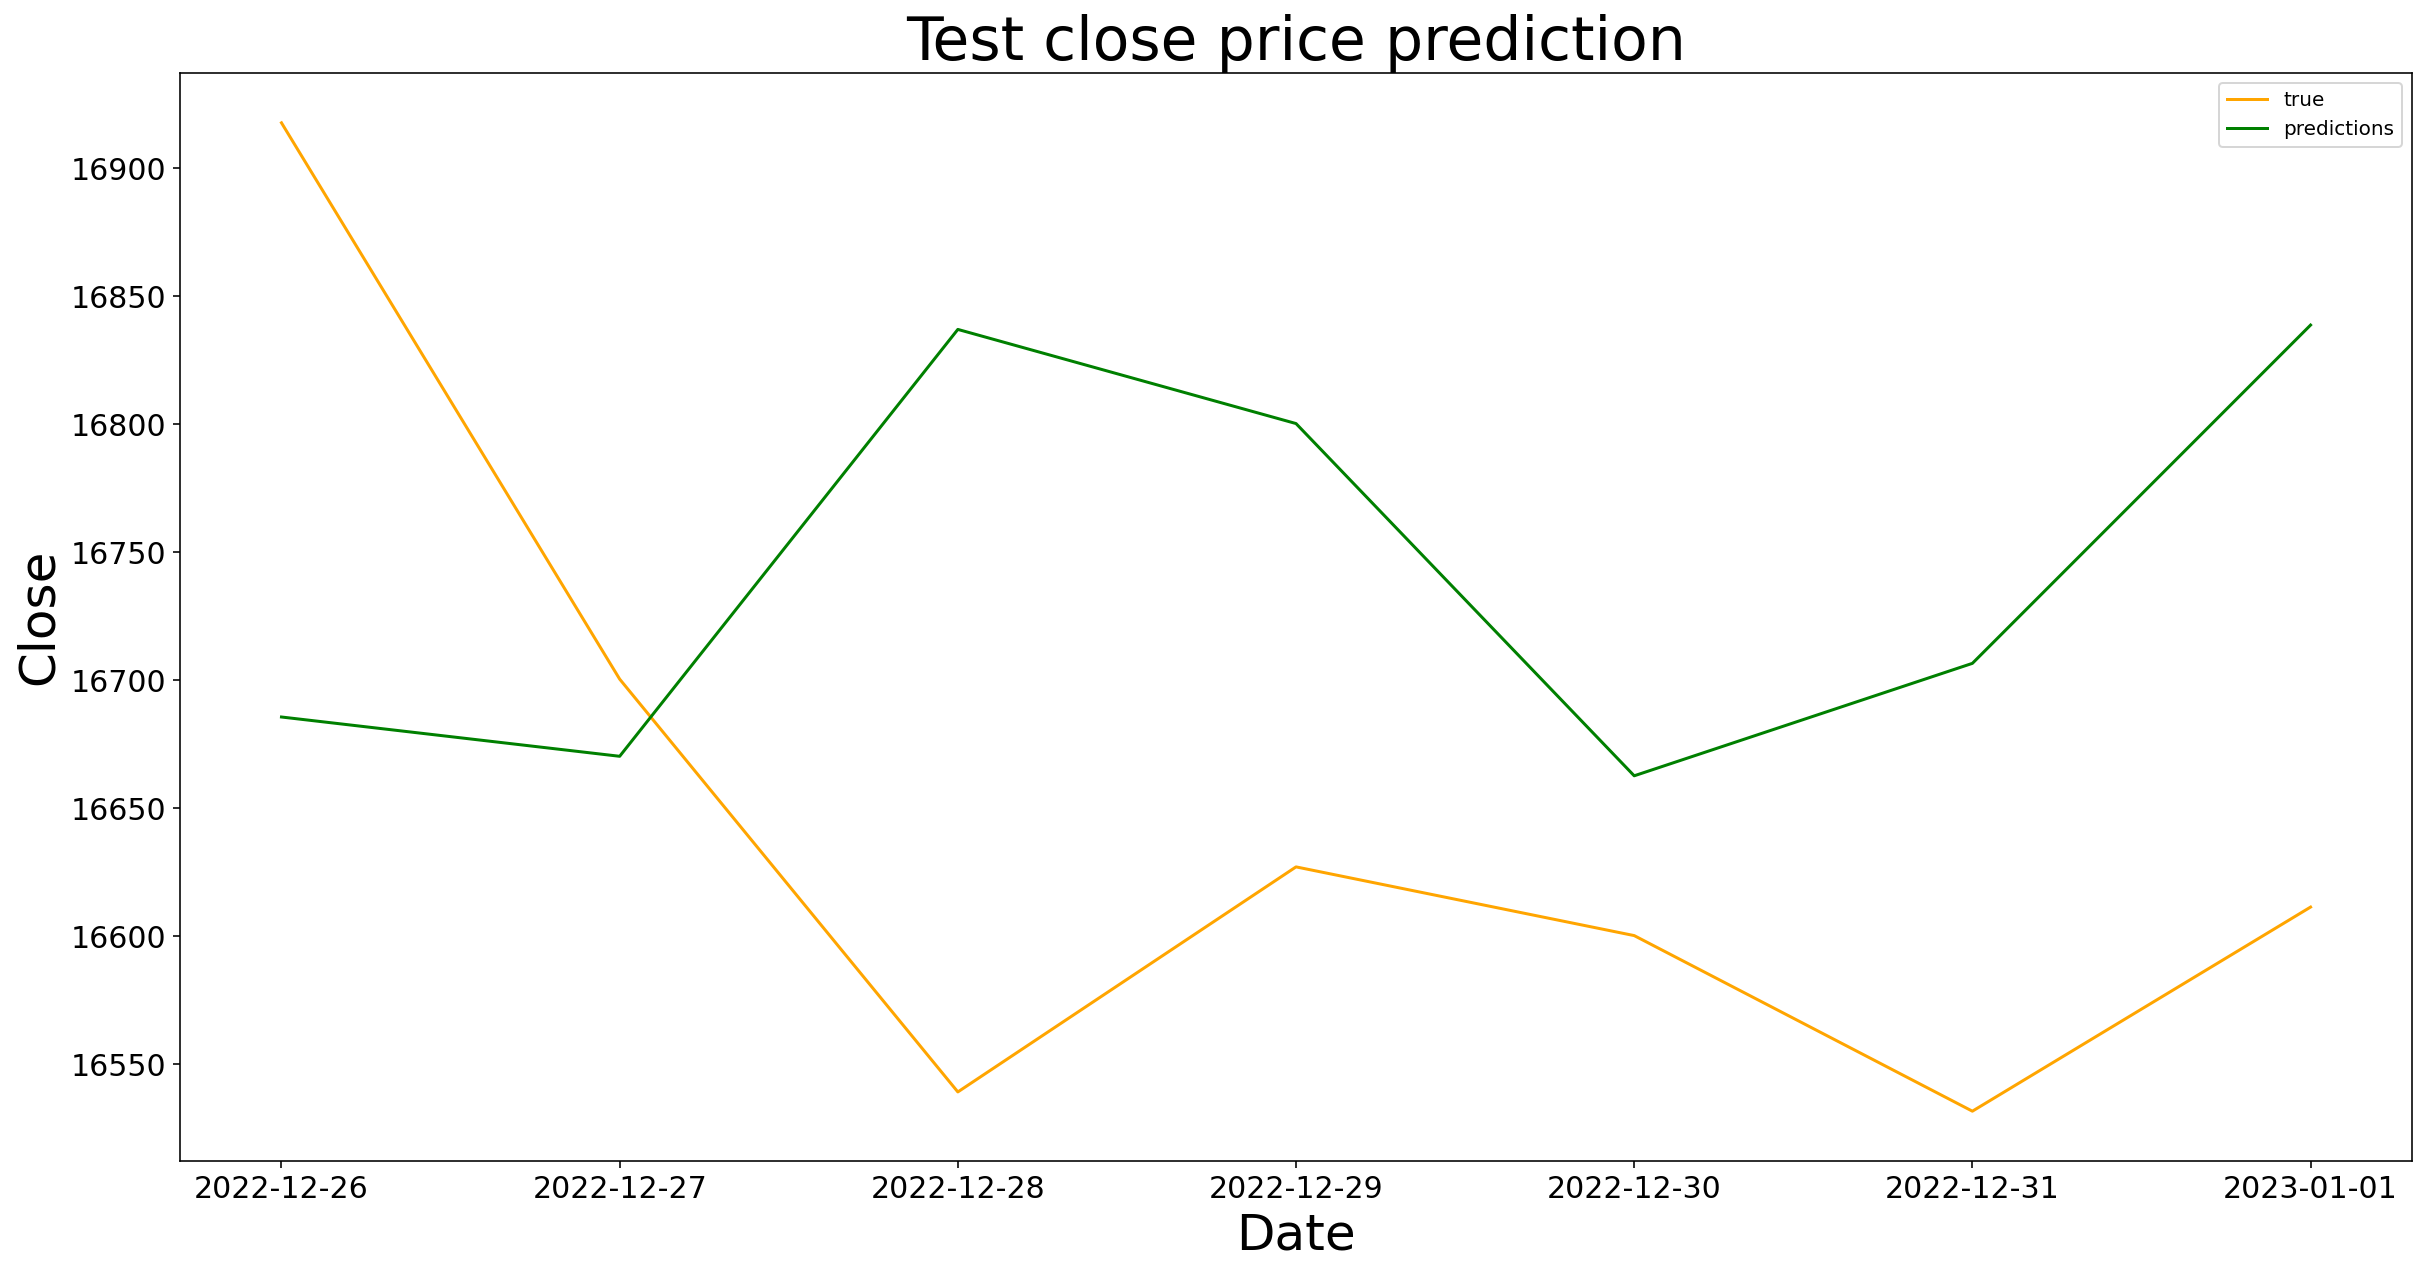

In [16]:
plt.plot(test_dates, test, color = 'orange', label = 'true')
plt.plot(test_dates, test_pred_, color = 'green', label = 'predictions')
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Close", fontsize = 25)
plt.title("Test close price prediction", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()
plt.show()

### Future predictions with best model. ###

In [17]:
best_order = best_arima_order
if test_RMSE < test_RMSE_:
    best_order = auto_arima_order

best_model = ARIMA(close, order=best_order).fit()
future_pred = best_model.forecast(period)
last_pred = future_pred[-1]
change_pred = (last_pred - close[-1]) / close[-1] * 100
print(f"Predicted price of {assets[0]} through {period} days = %.3f" % last_pred, sep="")
print(f"{assets[0]} change in percents = %.3f" % change_pred, '%', sep="")

Predicted price of bitcoin through 7 days = 16533.996
bitcoin change in percents = -0.466%


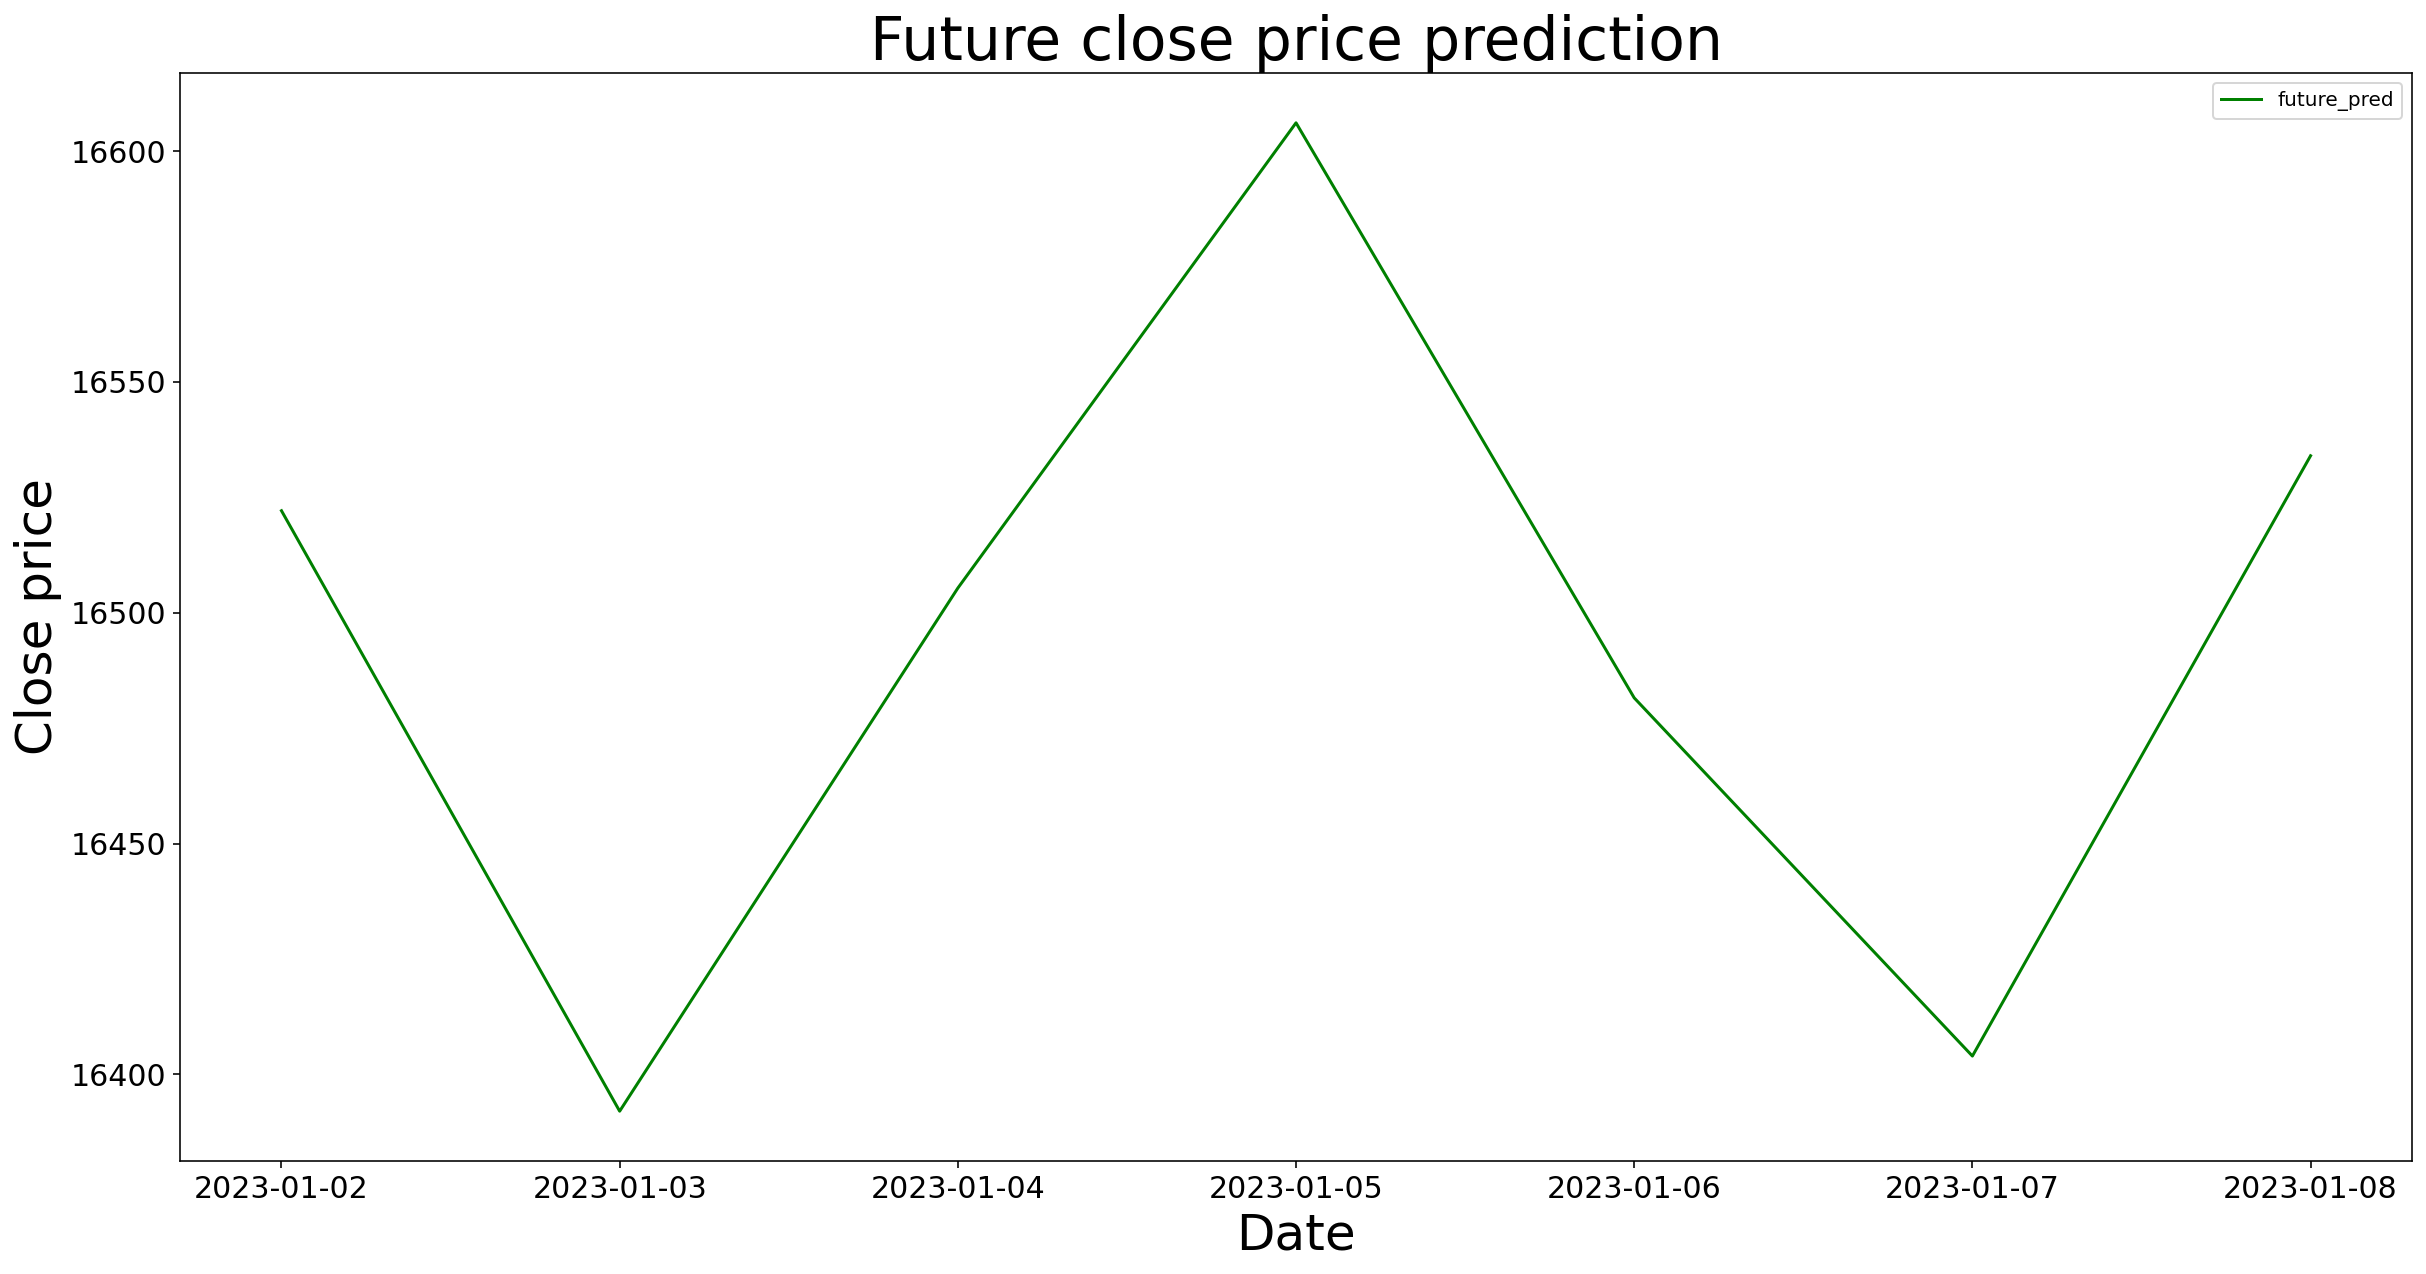

In [18]:
import pandas as pd
future_dates = pd.date_range(start='2023-01-02', end='2023-01-08')
plt.title("Future close price prediction", fontsize = 30)
plt.plot(future_dates, future_pred, color = 'green', label = 'future_pred')
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Close price", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()
plt.show()